Problem Description:

In the context of financial markets, understanding the underlying patterns and dynamics of stock movements is crucial for investors aiming to make informed decisions. This project seeks to unravel these patterns by leveraging unsupervised learning techniques to cluster stocks based on their historical trading data. The primary objective is to identify groups of stocks that exhibit similar trading behaviors over a specified period, facilitating a deeper understanding of market trends and stock relationships.

Data Collection and Preparation:

The project begins with the collection of minute-level historical trading data for a predefined list of stocks (e.g., SPY, QQQ, DIA, AAPL, MSFT) over a two-year period. This data includes trading metrics such as open, high, low, close prices, and volume. The data is fetched using the Interactive Brokers API, cleaned, and then aggregated to daily levels to reduce noise and computational complexity.

Feature Engineering:

To capture the essence of stock movements, a comprehensive feature engineering process is implemented. This process includes the computation of various technical indicators, such as Simple Moving Averages (SMA), Exponential Moving Averages (EMA), Relative Strength Index (RSI), Bollinger Bands, and others. These indicators serve as the basis for understanding the stocks' price movements and volatility, enabling the model to capture nuanced patterns in the data.

Clustering Approach:

The project employs KMeans clustering, a popular unsupervised learning algorithm, to group stocks based on the similarity of their features. Before clustering, the feature set undergoes scaling to ensure equal importance is given to all variables, and dimensionality reduction through Principal Component Analysis (PCA) to reduce the computational complexity while retaining the most informative aspects of the data. The optimal number of clusters is determined by evaluating various metrics, such as the silhouette score, Davies-Bouldin index, and Calinski-Harabasz index, for different cluster counts.

Outcome and Visualization:

The final outcome is a set of clusters that categorize stocks with similar trading patterns, potentially uncovering latent market dynamics. Visualization of these clusters through scatter plots and other graphical representations provides intuitive insights into the relationships and grouping of stocks, offering valuable information for portfolio management, risk assessment, and investment strategy formulation.

Unsupervised Learning Problem:

The unsupervised learning problem tackled by this project involves identifying inherent groupings in financial market data without prior labeling. The challenge lies in selecting appropriate features that accurately represent the data, determining the optimal number of clusters, and interpreting the resulting clusters in a meaningful way that provides actionable insights for financial analysis and decision-making.

G

## 1. Imports

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import os
import threading
import time
from datetime import datetime, timedelta
from pytz import timezone
import pytz
from ibapi.client import EClient
from ibapi.wrapper import EWrapper
from ibapi.contract import Contract
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.cluster import KMeans
from ta.trend import SMAIndicator, EMAIndicator
from ta.momentum import RSIIndicator
from ta.volatility import BollingerBands
import functools
import psutil

os.environ["OMP_NUM_THREADS"] = "3"
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S', handlers=[logging.FileHandler("data_quality.log"), logging.StreamHandler()])

## 2. Pull Stock Data

In [6]:
# Constants and Configuration
IB_HOST = '127.0.0.1'
IB_PORT = 7496
IB_CLIENT_ID = 123
TICKERS = ["SPY", "QQQ", "DIA", "IWM", "AAPL", "MSFT", "GOOGL", "SMH", "AMZN", "NVDA", "META", "JPM", "BAC", "PG", "MCD", "JNJ", "PFE", "XOM", "CVX", "D", "SO", "UPS", "LUV"]
# START_DATE = "2022, 2, 28"
# END_DATE = "2024, 2, 28"
# TIME_DELTAS = {'ONE_YEAR': timedelta(days=365), 'TWO_YEAR': timedelta(days=730)}

# Threading Lock for Data Access
data_lock = threading.Lock()


class IBapi(EWrapper, EClient):
    def __init__(self):
        EClient.__init__(self, self)
        self.data = []
        self.data_ready = threading.Event()

    def historicalData(self, reqId, bar):
        with data_lock:
            self.data.append([reqId, bar.date, bar.open, bar.high, bar.low, bar.close, bar.volume])

    def historicalDataEnd(self, reqId, start, end):
        print(f"Historical data fetch complete for reqId {reqId}")
        self.data_ready.set()

class IBDataFetcher:
    def __init__(self):
        self.app = IBapi()
        self.combined_df = None

    def fetch_data(self, tickers, start_date, end_date):
        try:
            self.app.connect(IB_HOST, IB_PORT, IB_CLIENT_ID)

            # Starting the API thread
            api_thread = threading.Thread(target=self.app.run, daemon=True)
            api_thread.start()
            time.sleep(1)

            reqId = 1
            dfs = []

            for ticker in tickers:
                contract = self.create_contract(ticker)
                start_date_str = start_date.strftime("%Y%m%d %H:%M:%S")
                end_date_str = end_date.strftime("%Y%m%d %H:%M:%S")

                self.fetch_data_internal(self.app, contract, reqId, start_date_str, end_date_str)

                with data_lock:
                    df = self.save_to_dataframe(self.app.data)
                    self.app.data.clear()
                    df['Ticker'] = ticker  # Add a 'Ticker' column for identification
                    dfs.append(df)
                    reqId += 1

            self.combined_df = pd.concat(dfs, ignore_index=True)
            print(self.combined_df)

        except Exception as e:
            print(f"An error occurred: {e}")

        finally:
            self.app.disconnect()

    def get_utc_time(self, endDateTimeStr, local_tz='US/Eastern'):
        local = timezone(local_tz)
        endDateTime = datetime.strptime(endDateTimeStr, "%Y%m%d %H:%M:%S")
        local_time = local.localize(endDateTime)
        utc_time = local_time.astimezone(pytz.utc)
        return utc_time.strftime("%Y%m%d %H:%M:%S")

    def fetch_data_internal(self, app, contract, reqId, startDateTimeStr, endDateTimeStr):
        start_utc_time = self.get_utc_time(startDateTimeStr)
        end_utc_time = self.get_utc_time(endDateTimeStr)

        app.reqHistoricalData(reqId=reqId, 
                             contract=contract, 
                             endDateTime=end_utc_time, 
                             durationStr='2 Y',  # Adjusted to fetch data for 2 years
                             barSizeSetting='1 min',  # Adjusted to fetch daily data
                             whatToShow='TRADES', 
                             useRTH=True, 
                             formatDate=1, 
                             keepUpToDate=False, 
                             chartOptions=[])

        app.data_ready.wait()
        app.data_ready.clear()

    def create_contract(self, ticker):
        contract = Contract()
        contract.symbol = ticker
        contract.secType = 'STK'
        contract.exchange = 'SMART'
        contract.currency = 'USD'
        return contract

    def save_to_dataframe(self, data):
        columns = ['TickerID', 'Date', 'Open', 'High', 'Low', 'Close', 'Volume']
        df = pd.DataFrame(data, columns=columns)
        return df

In [7]:
ib_data_fetcher = IBDataFetcher()
ib_data_fetcher.fetch_data(TICKERS, datetime(2022, 2, 28), datetime(2024, 2, 28))  # Fetch data for all tickers
df = ib_data_fetcher.combined_df  # Access the combined DataFrame
df.to_csv("MarketPillars_2yr_1min2.csv")

2024-03-01 10:22:41 - INFO - sent startApi
2024-03-01 10:22:41 - INFO - REQUEST startApi {}
2024-03-01 10:22:41 - INFO - SENDING startApi b'\x00\x00\x00\n71\x002\x00123\x00\x00'
2024-03-01 10:22:41 - INFO - ANSWER connectAck {}
2024-03-01 10:22:41 - INFO - ANSWER managedAccounts {'accountsList': 'U4776896'}
2024-03-01 10:22:41 - INFO - ANSWER nextValidId {'orderId': 1}
2024-03-01 10:22:41 - INFO - ANSWER error {'reqId': -1, 'errorCode': 2104, 'errorString': 'Market data farm connection is OK:usfarm.nj'}
2024-03-01 10:22:41 - ERROR - ERROR -1 2104 Market data farm connection is OK:usfarm.nj
2024-03-01 10:22:41 - INFO - ANSWER error {'reqId': -1, 'errorCode': 2104, 'errorString': 'Market data farm connection is OK:cashfarm'}
2024-03-01 10:22:41 - ERROR - ERROR -1 2104 Market data farm connection is OK:cashfarm
2024-03-01 10:22:41 - INFO - ANSWER error {'reqId': -1, 'errorCode': 2104, 'errorString': 'Market data farm connection is OK:usfarm'}
2024-03-01 10:22:41 - ERROR - ERROR -1 2104 Ma

Historical data fetch complete for reqId 1


2024-03-01 10:33:15 - INFO - SENDING reqHistoricalData b'\x00\x00\x00O20\x002\x000\x00QQQ\x00STK\x00\x000.0\x00\x00\x00SMART\x00\x00USD\x00\x00\x000\x0020240228 05:00:00\x001 min\x002 Y\x001\x00TRADES\x001\x000\x00\x00'
2024-03-01 10:43:59 - INFO - ANSWER error {'reqId': 2, 'errorCode': 2176, 'errorString': 'Warning: Your API version does not support fractional share size rules. Please upgrade to a minimum version 163. Trimmed value 7514.63 to 7514'}
2024-03-01 10:43:59 - ERROR - ERROR 2 2176 Warning: Your API version does not support fractional share size rules. Please upgrade to a minimum version 163. Trimmed value 7514.63 to 7514
2024-03-01 10:44:06 - INFO - REQUEST reqHistoricalData {'reqId': 3, 'contract': 1772067065872: 0,DIA,STK,,0.0,,,SMART,,USD,,,False,,combo:, 'endDateTime': '20240228 05:00:00', 'durationStr': '2 Y', 'barSizeSetting': '1 min', 'whatToShow': 'TRADES', 'useRTH': True, 'formatDate': 1, 'keepUpToDate': False, 'chartOptions': []}
2024-03-01 10:44:06 - INFO - SENDI

Historical data fetch complete for reqId 2


2024-03-01 10:54:53 - INFO - ANSWER error {'reqId': 3, 'errorCode': 2176, 'errorString': 'Warning: Your API version does not support fractional share size rules. Please upgrade to a minimum version 163. Trimmed value 1411.47 to 1411'}
2024-03-01 10:54:53 - ERROR - ERROR 3 2176 Warning: Your API version does not support fractional share size rules. Please upgrade to a minimum version 163. Trimmed value 1411.47 to 1411
2024-03-01 10:54:59 - INFO - REQUEST reqHistoricalData {'reqId': 4, 'contract': 1772394573008: 0,IWM,STK,,0.0,,,SMART,,USD,,,False,,combo:, 'endDateTime': '20240228 05:00:00', 'durationStr': '2 Y', 'barSizeSetting': '1 min', 'whatToShow': 'TRADES', 'useRTH': True, 'formatDate': 1, 'keepUpToDate': False, 'chartOptions': []}
2024-03-01 10:54:59 - INFO - SENDING reqHistoricalData b'\x00\x00\x00O20\x004\x000\x00IWM\x00STK\x00\x000.0\x00\x00\x00SMART\x00\x00USD\x00\x00\x000\x0020240228 05:00:00\x001 min\x002 Y\x001\x00TRADES\x001\x000\x00\x00'


Historical data fetch complete for reqId 3


2024-03-01 11:05:47 - INFO - ANSWER error {'reqId': 4, 'errorCode': 2176, 'errorString': 'Warning: Your API version does not support fractional share size rules. Please upgrade to a minimum version 163. Trimmed value 3464.24 to 3464'}
2024-03-01 11:05:47 - ERROR - ERROR 4 2176 Warning: Your API version does not support fractional share size rules. Please upgrade to a minimum version 163. Trimmed value 3464.24 to 3464
2024-03-01 11:05:55 - INFO - REQUEST reqHistoricalData {'reqId': 5, 'contract': 1772246678864: 0,AAPL,STK,,0.0,,,SMART,,USD,,,False,,combo:, 'endDateTime': '20240228 05:00:00', 'durationStr': '2 Y', 'barSizeSetting': '1 min', 'whatToShow': 'TRADES', 'useRTH': True, 'formatDate': 1, 'keepUpToDate': False, 'chartOptions': []}
2024-03-01 11:05:55 - INFO - SENDING reqHistoricalData b'\x00\x00\x00P20\x005\x000\x00AAPL\x00STK\x00\x000.0\x00\x00\x00SMART\x00\x00USD\x00\x00\x000\x0020240228 05:00:00\x001 min\x002 Y\x001\x00TRADES\x001\x000\x00\x00'


Historical data fetch complete for reqId 4


2024-03-01 11:16:42 - INFO - ANSWER error {'reqId': 5, 'errorCode': 2176, 'errorString': 'Warning: Your API version does not support fractional share size rules. Please upgrade to a minimum version 163. Trimmed value 3475.14 to 3475'}
2024-03-01 11:16:42 - ERROR - ERROR 5 2176 Warning: Your API version does not support fractional share size rules. Please upgrade to a minimum version 163. Trimmed value 3475.14 to 3475
2024-03-01 11:16:48 - INFO - REQUEST reqHistoricalData {'reqId': 6, 'contract': 1772196761808: 0,MSFT,STK,,0.0,,,SMART,,USD,,,False,,combo:, 'endDateTime': '20240228 05:00:00', 'durationStr': '2 Y', 'barSizeSetting': '1 min', 'whatToShow': 'TRADES', 'useRTH': True, 'formatDate': 1, 'keepUpToDate': False, 'chartOptions': []}
2024-03-01 11:16:48 - INFO - SENDING reqHistoricalData b'\x00\x00\x00P20\x006\x000\x00MSFT\x00STK\x00\x000.0\x00\x00\x00SMART\x00\x00USD\x00\x00\x000\x0020240228 05:00:00\x001 min\x002 Y\x001\x00TRADES\x001\x000\x00\x00'


Historical data fetch complete for reqId 5


2024-03-01 11:27:42 - INFO - ANSWER error {'reqId': 6, 'errorCode': 2176, 'errorString': 'Warning: Your API version does not support fractional share size rules. Please upgrade to a minimum version 163. Trimmed value 4728.17 to 4728'}
2024-03-01 11:27:42 - ERROR - ERROR 6 2176 Warning: Your API version does not support fractional share size rules. Please upgrade to a minimum version 163. Trimmed value 4728.17 to 4728
2024-03-01 11:27:48 - INFO - REQUEST reqHistoricalData {'reqId': 7, 'contract': 1772246678608: 0,GOOGL,STK,,0.0,,,SMART,,USD,,,False,,combo:, 'endDateTime': '20240228 05:00:00', 'durationStr': '2 Y', 'barSizeSetting': '1 min', 'whatToShow': 'TRADES', 'useRTH': True, 'formatDate': 1, 'keepUpToDate': False, 'chartOptions': []}
2024-03-01 11:27:48 - INFO - SENDING reqHistoricalData b'\x00\x00\x00Q20\x007\x000\x00GOOGL\x00STK\x00\x000.0\x00\x00\x00SMART\x00\x00USD\x00\x00\x000\x0020240228 05:00:00\x001 min\x002 Y\x001\x00TRADES\x001\x000\x00\x00'


Historical data fetch complete for reqId 6


2024-03-01 11:38:12 - INFO - ANSWER error {'reqId': 7, 'errorCode': 2176, 'errorString': 'Warning: Your API version does not support fractional share size rules. Please upgrade to a minimum version 163. Trimmed value 5060.8 to 5060'}
2024-03-01 11:38:12 - ERROR - ERROR 7 2176 Warning: Your API version does not support fractional share size rules. Please upgrade to a minimum version 163. Trimmed value 5060.8 to 5060
2024-03-01 11:38:19 - INFO - REQUEST reqHistoricalData {'reqId': 8, 'contract': 1772246678352: 0,SMH,STK,,0.0,,,SMART,,USD,,,False,,combo:, 'endDateTime': '20240228 05:00:00', 'durationStr': '2 Y', 'barSizeSetting': '1 min', 'whatToShow': 'TRADES', 'useRTH': True, 'formatDate': 1, 'keepUpToDate': False, 'chartOptions': []}
2024-03-01 11:38:19 - INFO - SENDING reqHistoricalData b'\x00\x00\x00O20\x008\x000\x00SMH\x00STK\x00\x000.0\x00\x00\x00SMART\x00\x00USD\x00\x00\x000\x0020240228 05:00:00\x001 min\x002 Y\x001\x00TRADES\x001\x000\x00\x00'


Historical data fetch complete for reqId 7


2024-03-01 11:49:00 - INFO - ANSWER error {'reqId': 8, 'errorCode': 2176, 'errorString': 'Warning: Your API version does not support fractional share size rules. Please upgrade to a minimum version 163. Trimmed value 196.16 to 196'}
2024-03-01 11:49:00 - ERROR - ERROR 8 2176 Warning: Your API version does not support fractional share size rules. Please upgrade to a minimum version 163. Trimmed value 196.16 to 196
2024-03-01 11:49:06 - INFO - REQUEST reqHistoricalData {'reqId': 9, 'contract': 1772195979280: 0,AMZN,STK,,0.0,,,SMART,,USD,,,False,,combo:, 'endDateTime': '20240228 05:00:00', 'durationStr': '2 Y', 'barSizeSetting': '1 min', 'whatToShow': 'TRADES', 'useRTH': True, 'formatDate': 1, 'keepUpToDate': False, 'chartOptions': []}
2024-03-01 11:49:06 - INFO - SENDING reqHistoricalData b'\x00\x00\x00P20\x009\x000\x00AMZN\x00STK\x00\x000.0\x00\x00\x00SMART\x00\x00USD\x00\x00\x000\x0020240228 05:00:00\x001 min\x002 Y\x001\x00TRADES\x001\x000\x00\x00'


Historical data fetch complete for reqId 8


2024-03-01 11:59:54 - INFO - ANSWER error {'reqId': 9, 'errorCode': 2176, 'errorString': 'Warning: Your API version does not support fractional share size rules. Please upgrade to a minimum version 163. Trimmed value 6542.6 to 6542'}
2024-03-01 11:59:54 - ERROR - ERROR 9 2176 Warning: Your API version does not support fractional share size rules. Please upgrade to a minimum version 163. Trimmed value 6542.6 to 6542
2024-03-01 12:00:01 - INFO - REQUEST reqHistoricalData {'reqId': 10, 'contract': 1772394574928: 0,NVDA,STK,,0.0,,,SMART,,USD,,,False,,combo:, 'endDateTime': '20240228 05:00:00', 'durationStr': '2 Y', 'barSizeSetting': '1 min', 'whatToShow': 'TRADES', 'useRTH': True, 'formatDate': 1, 'keepUpToDate': False, 'chartOptions': []}
2024-03-01 12:00:01 - INFO - SENDING reqHistoricalData b'\x00\x00\x00Q20\x0010\x000\x00NVDA\x00STK\x00\x000.0\x00\x00\x00SMART\x00\x00USD\x00\x00\x000\x0020240228 05:00:00\x001 min\x002 Y\x001\x00TRADES\x001\x000\x00\x00'


Historical data fetch complete for reqId 9


2024-03-01 12:10:48 - INFO - ANSWER error {'reqId': 10, 'errorCode': 2176, 'errorString': 'Warning: Your API version does not support fractional share size rules. Please upgrade to a minimum version 163. Trimmed value 5783.27 to 5783'}
2024-03-01 12:10:48 - ERROR - ERROR 10 2176 Warning: Your API version does not support fractional share size rules. Please upgrade to a minimum version 163. Trimmed value 5783.27 to 5783
2024-03-01 12:10:55 - INFO - REQUEST reqHistoricalData {'reqId': 11, 'contract': 1772196308880: 0,META,STK,,0.0,,,SMART,,USD,,,False,,combo:, 'endDateTime': '20240228 05:00:00', 'durationStr': '2 Y', 'barSizeSetting': '1 min', 'whatToShow': 'TRADES', 'useRTH': True, 'formatDate': 1, 'keepUpToDate': False, 'chartOptions': []}
2024-03-01 12:10:55 - INFO - SENDING reqHistoricalData b'\x00\x00\x00Q20\x0011\x000\x00META\x00STK\x00\x000.0\x00\x00\x00SMART\x00\x00USD\x00\x00\x000\x0020240228 05:00:00\x001 min\x002 Y\x001\x00TRADES\x001\x000\x00\x00'


Historical data fetch complete for reqId 10


2024-03-01 12:21:43 - INFO - ANSWER error {'reqId': 11, 'errorCode': 2176, 'errorString': 'Warning: Your API version does not support fractional share size rules. Please upgrade to a minimum version 163. Trimmed value 3812.97 to 3812'}
2024-03-01 12:21:43 - ERROR - ERROR 11 2176 Warning: Your API version does not support fractional share size rules. Please upgrade to a minimum version 163. Trimmed value 3812.97 to 3812
2024-03-01 12:21:49 - INFO - REQUEST reqHistoricalData {'reqId': 12, 'contract': 1772200098768: 0,JPM,STK,,0.0,,,SMART,,USD,,,False,,combo:, 'endDateTime': '20240228 05:00:00', 'durationStr': '2 Y', 'barSizeSetting': '1 min', 'whatToShow': 'TRADES', 'useRTH': True, 'formatDate': 1, 'keepUpToDate': False, 'chartOptions': []}
2024-03-01 12:21:49 - INFO - SENDING reqHistoricalData b'\x00\x00\x00P20\x0012\x000\x00JPM\x00STK\x00\x000.0\x00\x00\x00SMART\x00\x00USD\x00\x00\x000\x0020240228 05:00:00\x001 min\x002 Y\x001\x00TRADES\x001\x000\x00\x00'


Historical data fetch complete for reqId 11


2024-03-01 12:32:42 - INFO - ANSWER error {'reqId': 12, 'errorCode': 2176, 'errorString': 'Warning: Your API version does not support fractional share size rules. Please upgrade to a minimum version 163. Trimmed value 4135.89 to 4135'}
2024-03-01 12:32:42 - ERROR - ERROR 12 2176 Warning: Your API version does not support fractional share size rules. Please upgrade to a minimum version 163. Trimmed value 4135.89 to 4135
2024-03-01 12:32:48 - INFO - REQUEST reqHistoricalData {'reqId': 13, 'contract': 1772198619984: 0,BAC,STK,,0.0,,,SMART,,USD,,,False,,combo:, 'endDateTime': '20240228 05:00:00', 'durationStr': '2 Y', 'barSizeSetting': '1 min', 'whatToShow': 'TRADES', 'useRTH': True, 'formatDate': 1, 'keepUpToDate': False, 'chartOptions': []}
2024-03-01 12:32:48 - INFO - SENDING reqHistoricalData b'\x00\x00\x00P20\x0013\x000\x00BAC\x00STK\x00\x000.0\x00\x00\x00SMART\x00\x00USD\x00\x00\x000\x0020240228 05:00:00\x001 min\x002 Y\x001\x00TRADES\x001\x000\x00\x00'


Historical data fetch complete for reqId 12


2024-03-01 12:43:12 - INFO - ANSWER error {'reqId': 13, 'errorCode': 2176, 'errorString': 'Warning: Your API version does not support fractional share size rules. Please upgrade to a minimum version 163. Trimmed value 11532.54 to 11532'}
2024-03-01 12:43:12 - ERROR - ERROR 13 2176 Warning: Your API version does not support fractional share size rules. Please upgrade to a minimum version 163. Trimmed value 11532.54 to 11532
2024-03-01 12:43:19 - INFO - REQUEST reqHistoricalData {'reqId': 14, 'contract': 1772066123280: 0,PG,STK,,0.0,,,SMART,,USD,,,False,,combo:, 'endDateTime': '20240228 05:00:00', 'durationStr': '2 Y', 'barSizeSetting': '1 min', 'whatToShow': 'TRADES', 'useRTH': True, 'formatDate': 1, 'keepUpToDate': False, 'chartOptions': []}
2024-03-01 12:43:19 - INFO - SENDING reqHistoricalData b'\x00\x00\x00O20\x0014\x000\x00PG\x00STK\x00\x000.0\x00\x00\x00SMART\x00\x00USD\x00\x00\x000\x0020240228 05:00:00\x001 min\x002 Y\x001\x00TRADES\x001\x000\x00\x00'


Historical data fetch complete for reqId 13


2024-03-01 12:54:00 - INFO - ANSWER error {'reqId': 14, 'errorCode': 2176, 'errorString': 'Warning: Your API version does not support fractional share size rules. Please upgrade to a minimum version 163. Trimmed value 94.12 to 94'}
2024-03-01 12:54:00 - ERROR - ERROR 14 2176 Warning: Your API version does not support fractional share size rules. Please upgrade to a minimum version 163. Trimmed value 94.12 to 94
2024-03-01 12:54:08 - INFO - REQUEST reqHistoricalData {'reqId': 15, 'contract': 1772196593808: 0,MCD,STK,,0.0,,,SMART,,USD,,,False,,combo:, 'endDateTime': '20240228 05:00:00', 'durationStr': '2 Y', 'barSizeSetting': '1 min', 'whatToShow': 'TRADES', 'useRTH': True, 'formatDate': 1, 'keepUpToDate': False, 'chartOptions': []}
2024-03-01 12:54:08 - INFO - SENDING reqHistoricalData b'\x00\x00\x00P20\x0015\x000\x00MCD\x00STK\x00\x000.0\x00\x00\x00SMART\x00\x00USD\x00\x00\x000\x0020240228 05:00:00\x001 min\x002 Y\x001\x00TRADES\x001\x000\x00\x00'


Historical data fetch complete for reqId 14


2024-03-01 13:04:54 - INFO - ANSWER error {'reqId': 15, 'errorCode': 2176, 'errorString': 'Warning: Your API version does not support fractional share size rules. Please upgrade to a minimum version 163. Trimmed value 979.74 to 979'}
2024-03-01 13:04:54 - ERROR - ERROR 15 2176 Warning: Your API version does not support fractional share size rules. Please upgrade to a minimum version 163. Trimmed value 979.74 to 979
2024-03-01 13:05:03 - INFO - REQUEST reqHistoricalData {'reqId': 16, 'contract': 1772657836432: 0,JNJ,STK,,0.0,,,SMART,,USD,,,False,,combo:, 'endDateTime': '20240228 05:00:00', 'durationStr': '2 Y', 'barSizeSetting': '1 min', 'whatToShow': 'TRADES', 'useRTH': True, 'formatDate': 1, 'keepUpToDate': False, 'chartOptions': []}
2024-03-01 13:05:03 - INFO - SENDING reqHistoricalData b'\x00\x00\x00P20\x0016\x000\x00JNJ\x00STK\x00\x000.0\x00\x00\x00SMART\x00\x00USD\x00\x00\x000\x0020240228 05:00:00\x001 min\x002 Y\x001\x00TRADES\x001\x000\x00\x00'


Historical data fetch complete for reqId 15


2024-03-01 13:15:48 - INFO - ANSWER error {'reqId': 16, 'errorCode': 2176, 'errorString': 'Warning: Your API version does not support fractional share size rules. Please upgrade to a minimum version 163. Trimmed value 2195.46 to 2195'}
2024-03-01 13:15:48 - ERROR - ERROR 16 2176 Warning: Your API version does not support fractional share size rules. Please upgrade to a minimum version 163. Trimmed value 2195.46 to 2195
2024-03-01 13:15:55 - INFO - REQUEST reqHistoricalData {'reqId': 17, 'contract': 1772196242320: 0,PFE,STK,,0.0,,,SMART,,USD,,,False,,combo:, 'endDateTime': '20240228 05:00:00', 'durationStr': '2 Y', 'barSizeSetting': '1 min', 'whatToShow': 'TRADES', 'useRTH': True, 'formatDate': 1, 'keepUpToDate': False, 'chartOptions': []}
2024-03-01 13:15:55 - INFO - SENDING reqHistoricalData b'\x00\x00\x00P20\x0017\x000\x00PFE\x00STK\x00\x000.0\x00\x00\x00SMART\x00\x00USD\x00\x00\x000\x0020240228 05:00:00\x001 min\x002 Y\x001\x00TRADES\x001\x000\x00\x00'


Historical data fetch complete for reqId 16


2024-03-01 13:26:43 - INFO - ANSWER error {'reqId': 17, 'errorCode': 2176, 'errorString': 'Warning: Your API version does not support fractional share size rules. Please upgrade to a minimum version 163. Trimmed value 7911.6 to 7911'}
2024-03-01 13:26:43 - ERROR - ERROR 17 2176 Warning: Your API version does not support fractional share size rules. Please upgrade to a minimum version 163. Trimmed value 7911.6 to 7911
2024-03-01 13:26:50 - INFO - REQUEST reqHistoricalData {'reqId': 18, 'contract': 1772182642704: 0,XOM,STK,,0.0,,,SMART,,USD,,,False,,combo:, 'endDateTime': '20240228 05:00:00', 'durationStr': '2 Y', 'barSizeSetting': '1 min', 'whatToShow': 'TRADES', 'useRTH': True, 'formatDate': 1, 'keepUpToDate': False, 'chartOptions': []}
2024-03-01 13:26:50 - INFO - SENDING reqHistoricalData b'\x00\x00\x00P20\x0018\x000\x00XOM\x00STK\x00\x000.0\x00\x00\x00SMART\x00\x00USD\x00\x00\x000\x0020240228 05:00:00\x001 min\x002 Y\x001\x00TRADES\x001\x000\x00\x00'


Historical data fetch complete for reqId 17


2024-03-01 13:37:42 - INFO - ANSWER error {'reqId': 18, 'errorCode': 2176, 'errorString': 'Warning: Your API version does not support fractional share size rules. Please upgrade to a minimum version 163. Trimmed value 6164.38 to 6164'}
2024-03-01 13:37:42 - ERROR - ERROR 18 2176 Warning: Your API version does not support fractional share size rules. Please upgrade to a minimum version 163. Trimmed value 6164.38 to 6164
2024-03-01 13:37:51 - INFO - REQUEST reqHistoricalData {'reqId': 19, 'contract': 1772182399312: 0,CVX,STK,,0.0,,,SMART,,USD,,,False,,combo:, 'endDateTime': '20240228 05:00:00', 'durationStr': '2 Y', 'barSizeSetting': '1 min', 'whatToShow': 'TRADES', 'useRTH': True, 'formatDate': 1, 'keepUpToDate': False, 'chartOptions': []}
2024-03-01 13:37:51 - INFO - SENDING reqHistoricalData b'\x00\x00\x00P20\x0019\x000\x00CVX\x00STK\x00\x000.0\x00\x00\x00SMART\x00\x00USD\x00\x00\x000\x0020240228 05:00:00\x001 min\x002 Y\x001\x00TRADES\x001\x000\x00\x00'


Historical data fetch complete for reqId 18


2024-03-01 13:48:18 - INFO - ANSWER error {'reqId': 19, 'errorCode': 2176, 'errorString': 'Warning: Your API version does not support fractional share size rules. Please upgrade to a minimum version 163. Trimmed value 3746.05 to 3746'}
2024-03-01 13:48:18 - ERROR - ERROR 19 2176 Warning: Your API version does not support fractional share size rules. Please upgrade to a minimum version 163. Trimmed value 3746.05 to 3746
2024-03-01 13:48:26 - INFO - REQUEST reqHistoricalData {'reqId': 20, 'contract': 1772196242320: 0,D,STK,,0.0,,,SMART,,USD,,,False,,combo:, 'endDateTime': '20240228 05:00:00', 'durationStr': '2 Y', 'barSizeSetting': '1 min', 'whatToShow': 'TRADES', 'useRTH': True, 'formatDate': 1, 'keepUpToDate': False, 'chartOptions': []}
2024-03-01 13:48:26 - INFO - SENDING reqHistoricalData b'\x00\x00\x00N20\x0020\x000\x00D\x00STK\x00\x000.0\x00\x00\x00SMART\x00\x00USD\x00\x00\x000\x0020240228 05:00:00\x001 min\x002 Y\x001\x00TRADES\x001\x000\x00\x00'


Historical data fetch complete for reqId 19


2024-03-01 13:59:00 - INFO - ANSWER error {'reqId': 20, 'errorCode': 2176, 'errorString': 'Warning: Your API version does not support fractional share size rules. Please upgrade to a minimum version 163. Trimmed value 411.98 to 411'}
2024-03-01 13:59:00 - ERROR - ERROR 20 2176 Warning: Your API version does not support fractional share size rules. Please upgrade to a minimum version 163. Trimmed value 411.98 to 411
2024-03-01 13:59:08 - INFO - REQUEST reqHistoricalData {'reqId': 21, 'contract': 1772196757712: 0,SO,STK,,0.0,,,SMART,,USD,,,False,,combo:, 'endDateTime': '20240228 05:00:00', 'durationStr': '2 Y', 'barSizeSetting': '1 min', 'whatToShow': 'TRADES', 'useRTH': True, 'formatDate': 1, 'keepUpToDate': False, 'chartOptions': []}
2024-03-01 13:59:08 - INFO - SENDING reqHistoricalData b'\x00\x00\x00O20\x0021\x000\x00SO\x00STK\x00\x000.0\x00\x00\x00SMART\x00\x00USD\x00\x00\x000\x0020240228 05:00:00\x001 min\x002 Y\x001\x00TRADES\x001\x000\x00\x00'


Historical data fetch complete for reqId 20


2024-03-01 14:09:54 - INFO - ANSWER error {'reqId': 21, 'errorCode': 2176, 'errorString': 'Warning: Your API version does not support fractional share size rules. Please upgrade to a minimum version 163. Trimmed value 1198.6 to 1198'}
2024-03-01 14:09:54 - ERROR - ERROR 21 2176 Warning: Your API version does not support fractional share size rules. Please upgrade to a minimum version 163. Trimmed value 1198.6 to 1198
2024-03-01 14:10:02 - INFO - REQUEST reqHistoricalData {'reqId': 22, 'contract': 1772846420560: 0,UPS,STK,,0.0,,,SMART,,USD,,,False,,combo:, 'endDateTime': '20240228 05:00:00', 'durationStr': '2 Y', 'barSizeSetting': '1 min', 'whatToShow': 'TRADES', 'useRTH': True, 'formatDate': 1, 'keepUpToDate': False, 'chartOptions': []}
2024-03-01 14:10:02 - INFO - SENDING reqHistoricalData b'\x00\x00\x00P20\x0022\x000\x00UPS\x00STK\x00\x000.0\x00\x00\x00SMART\x00\x00USD\x00\x00\x000\x0020240228 05:00:00\x001 min\x002 Y\x001\x00TRADES\x001\x000\x00\x00'


Historical data fetch complete for reqId 21


2024-03-01 14:20:48 - INFO - ANSWER error {'reqId': 22, 'errorCode': 2176, 'errorString': 'Warning: Your API version does not support fractional share size rules. Please upgrade to a minimum version 163. Trimmed value 18.46 to 18'}
2024-03-01 14:20:48 - ERROR - ERROR 22 2176 Warning: Your API version does not support fractional share size rules. Please upgrade to a minimum version 163. Trimmed value 18.46 to 18
2024-03-01 14:20:56 - INFO - REQUEST reqHistoricalData {'reqId': 23, 'contract': 1772196242320: 0,LUV,STK,,0.0,,,SMART,,USD,,,False,,combo:, 'endDateTime': '20240228 05:00:00', 'durationStr': '2 Y', 'barSizeSetting': '1 min', 'whatToShow': 'TRADES', 'useRTH': True, 'formatDate': 1, 'keepUpToDate': False, 'chartOptions': []}
2024-03-01 14:20:56 - INFO - SENDING reqHistoricalData b'\x00\x00\x00P20\x0023\x000\x00LUV\x00STK\x00\x000.0\x00\x00\x00SMART\x00\x00USD\x00\x00\x000\x0020240228 05:00:00\x001 min\x002 Y\x001\x00TRADES\x001\x000\x00\x00'


Historical data fetch complete for reqId 22


2024-03-01 14:31:43 - INFO - ANSWER error {'reqId': 23, 'errorCode': 2176, 'errorString': 'Warning: Your API version does not support fractional share size rules. Please upgrade to a minimum version 163. Trimmed value 878.62 to 878'}
2024-03-01 14:31:43 - ERROR - ERROR 23 2176 Warning: Your API version does not support fractional share size rules. Please upgrade to a minimum version 163. Trimmed value 878.62 to 878


Historical data fetch complete for reqId 23


2024-03-01 14:31:52 - INFO - disconnecting
2024-03-01 14:31:52 - INFO - ANSWER connectionClosed {}


         TickerID                Date    Open    High     Low   Close  Volume  \
0               1  20220228  09:30:00  432.08  433.24  431.87  433.09   11781   
1               1  20220228  09:31:00  433.10  433.25  432.55  432.73    5705   
2               1  20220228  09:32:00  432.73  433.24  432.70  432.80    5161   
3               1  20220228  09:33:00  432.78  433.02  432.51  432.57    3915   
4               1  20220228  09:34:00  432.56  432.79  432.40  432.68    5444   
...           ...                 ...     ...     ...     ...     ...     ...   
4490099        23  20240227  15:55:00   34.42   34.45   34.41   34.42     571   
4490100        23  20240227  15:56:00   34.42   34.44   34.41   34.42     615   
4490101        23  20240227  15:57:00   34.42   34.42   34.40   34.41     386   
4490102        23  20240227  15:58:00   34.41   34.43   34.40   34.43     898   
4490103        23  20240227  15:59:00   34.43   34.52   34.42   34.52    2418   

        Ticker  
0         

In [2]:
filename = "MarketPillars_2yr_1min2.csv"

## 3. Data Processing

In [5]:
def timer(func):
    """Decorator for timing functions."""
    @functools.wraps(func)
    def wrapper_timer(*args, **kwargs):
        start_time = time.perf_counter()
        value = func(*args, **kwargs)
        end_time = time.perf_counter()
        run_time = end_time - start_time
        print(f"Finished {func.__name__!r} in {run_time:.4f} secs")
        return value
    return wrapper_timer


@timer
def load_data(filepath, advanced_imputation=None):
    """Load data from CSV file."""
    logging.info(f"Loading data from {filepath}")
    data = pd.read_csv(filepath)
    data = data.drop(["TickerID", "Unnamed: 0"], axis=1)
    data["Date"] = pd.to_datetime(data["Date"], format="%Y%m%d %H:%M:%S")

    # Log the count of null values
    data = data.replace([np.inf, -np.inf], np.nan)
    null_counts = data.isnull().sum()
    logging.info(f"Null values before imputation:\n{null_counts}")

    # Imputation
    if advanced_imputation:
        data.groupby("Ticker").apply(advanced_imputation)
    else:
        data.groupby("Ticker").apply(lambda ticker_data: ticker_data.fillna(method="ffill").fillna(method="bfill"))
    logging.info("Data loading and initial imputation complete.")
    return data


def aggregate_to_daily(minute_data):
    """Converts minute-wise data into daily data."""
    minute_data["Date"] = pd.to_datetime(minute_data["Date"])
    minute_data.set_index("Date", inplace=True)
    daily_data = minute_data.resample("D").agg({
        "Open": "first",
        "High": "max",
        "Low": "min",
        "Close": "last",
        "Volume": "sum"
    })
    return daily_data.reset_index()     


@timer
def feature_engineering(df):
    """Perform feature engineering on the dataset."""
    logging.info("Starting feature engineering process.")
    res = pd.DataFrame()
    scaler = RobustScaler()
    tickers = df["Ticker"].unique()

    for unique_ticker in tickers:
        data = df[df["Ticker"] == unique_ticker].copy()    
        try:
            # Simple moving averages
            data["SMA_200"] = SMAIndicator(close=data["Close"], window=200).sma_indicator()
            data["SMA_50"] = SMAIndicator(close=data["Close"], window=50).sma_indicator()
            data["SMA_crossover"] = (data["SMA_50"] > data["SMA_200"]).astype(int)

            # Exponential moving averages
            data["EMA_50"] = data["Close"].ewm(span=50, adjust=False).mean()
            data["EMA_200"] = data["Close"].ewm(span=200, adjust=False).mean()
            data["EMA_crossover"] = (data["EMA_50"] > data["EMA_200"]).astype(int)

            # MACD
            data["MACD"] = data["EMA_50"] - data["EMA_200"]
            data["MACD_Signal"] = data["MACD"].ewm(span=50, adjust=False).mean()
            
            # RSI
            data["RSI_28"] = RSIIndicator(close=data["Close"], window=28).rsi()

            # Bollinger Bands
            std_dev = data["Close"].rolling(window=90).std()
            data["Upper_Band"] = data["SMA_200"] + (std_dev * 2)
            data["Lower_Band"] = data["SMA_200"] - (std_dev * 2)
            data["Bollinger_Width"] = data["Upper_Band"] - data["Lower_Band"]
            
            # ATR
            data["Previous Close"] = data["Close"].shift(1)
            data["High-Low"] = data["High"] - data["Low"]
            data["High-Previous Close"] = abs(data["High"] - data["Previous Close"])
            data["Low-Previous Close"] = abs(data["Low"] - data["Previous Close"])
            data["TR"] = data[["High-Low", "High-Previous Close", "Low-Previous Close"]].max(axis=1)
            data["ATR_28"] = data["TR"].rolling(window=28).mean()
           
            # Price Change Indicator
            data["Close_60D_pct_change"] = data["Close"].pct_change(periods=59)

            # Uptrend/Downtrend Indicators
            two_month_max_close = data["Close"].rolling(window=40).max()
            two_month_min_close = data["Close"].rolling(window=40).min()

            data["uptrend"] = (data["Close"] > two_month_max_close * (1 + 0.1)).astype(int) * 5
            data["downtrend"] = (data["Close"] < two_month_min_close * (1 - 0.1)).astype(int) * 5

            # Dropping undesired columns for KMeans
            data = data.drop(columns=["Open", "High", "Low", "Close", "Volume", "SMA_50", "SMA_200", "EMA_50", "EMA_200", "High-Low", "High-Previous Close", "Low-Previous Close", "Previous Close"])
            
            # Handling infinite values if present
            data = data.replace([np.inf, -np.inf], np.nan)

            # Scaling - Exclude binary indicators from scaling
            features_to_scale = ["Upper_Band", "Lower_Band", "MACD_Signal", "RSI_28", "ATR_28", "Close_60D_pct_change", "Bollinger_Width"]
            data[features_to_scale] = scaler.fit_transform(data[features_to_scale])

            res = pd.concat([res, data], axis=0)
        except Exception as e:
            logging.error(f"Error during feature engineering: {e}")
    logging.info("Feature engineering process completed.")
    return res


@timer
def aggregate_data(data):
    """Aggregate features across tickers to produce a representation of the overall market."""
    try:
        logging.info("Data aggregation has begun.")
        data = data.drop("Ticker",axis=1).groupby("Date").mean().reset_index()
        data.set_index("Date",inplace=True)
        logging.info("Data aggregation has completed.")
        return data.fillna(method="ffill").fillna(method="bfill")
    except Exception as e:
        logging.error(f"An error occurred during data aggregation: {e}")
        return None
    
    
@timer
def scale_reduce_and_pca(scaled_data):
    """Reduce the dimensionality of the data."""
    datecol = scaled_data.index
    scaled_data = scaled_data.select_dtypes("number")
    reduced_data = None
    pca_data = None
    
    # Feature Selection
    undesired_cols = ["Date"]
    selected_cols = [col for col in scaled_data.select_dtypes("number").columns if col not in undesired_cols]
    variance_threshold = scaled_data[selected_cols].var().quantile(.20)
    
    try:
        logging.info(f"Feature selection beginning on {scaled_data.shape[1]} features.")
        selector = VarianceThreshold(threshold=variance_threshold)
        reduced_data = selector.fit_transform(scaled_data)
        logging.info(f"Feature selection completed with {reduced_data.shape[1]} features.")
    except Exception as e:
        logging.error(f"Feature selection error: {e}")
        reduced_data = scaled_data  # Fallback to scaled_data if feature selection fails

    # Dimensionality reduction
    if reduced_data is not None:
        try:
            pca = PCA(n_components=0.95)
            pca_data = pca.fit_transform(reduced_data)
            logging.info("Dimensionality reduction successful.")
        except Exception as e:
            logging.error(f"Dimensionality reduction error: {e}")
            pca_data = reduced_data  # Fallback to reduced_data if dimensionality reduction fails

    if pca_data is not None:
        res = pd.DataFrame(pca_data)
        res.index = datecol
        return res
    else:
        logging.info("Returning original data due to errors in both feature selection and dimensionality reduction.")
        return scaled_data
    return

# 4. EDA

2024-03-05 06:37:54 - INFO - Loading data from MarketPillars_2yr_1min2.csv
2024-03-05 06:38:13 - INFO - Null values before imputation:
Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
Ticker    0
dtype: int64
2024-03-05 06:38:14 - INFO - Data loading and initial imputation complete.


Finished 'load_data' in 19.9496 secs


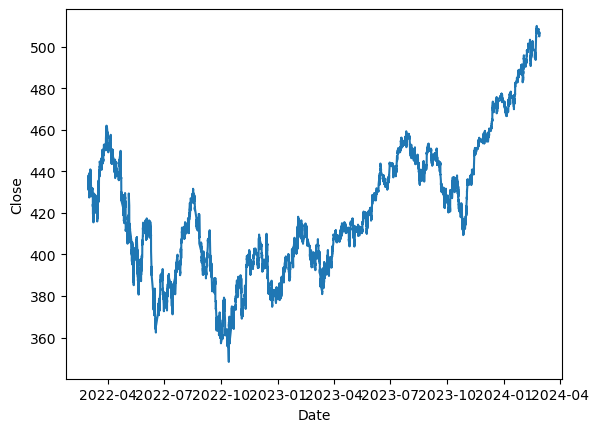

In [6]:
df = load_data(filename, advanced_imputation=None)
spydata=df[df["Ticker"]=="SPY"]
sns.lineplot(data=spydata, x="Date", y="Close");

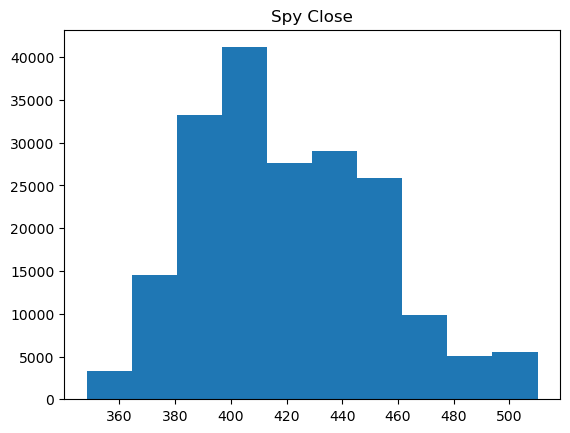

In [8]:
plt.hist(spydata["Close"])
plt.title("SPY Close");

## 5. Performance Evaluation

In [ ]:
@timer
def calculate_metrics(data, cluster_range=10):
    """Calculate clustering metrics for different numbers of clusters."""
    metrics = {
        "n_clusters": [],
        "Silhouette Score": [],
        "WCSS": [],
        "Davies-Bouldin Index": [],
        "Calinski-Harabasz Index": []
    }
    
    for n_clusters in range(2, cluster_range):
        clusterer = KMeans(n_clusters=n_clusters, random_state=42)
        labels = clusterer.fit_predict(data)
        
        # Store number of clusters
        metrics["n_clusters"].append(n_clusters)
        
        # Calculate and store metrics
        silhouette = silhouette_score(data, labels)
        wcss = clusterer.inertia_
        davies = davies_bouldin_score(data, labels)
        calinski = calinski_harabasz_score(data, labels)
        
        metrics["Silhouette Score"].append(silhouette)
        metrics["WCSS"].append(wcss)
        metrics["Davies-Bouldin Index"].append(davies)
        metrics["Calinski-Harabasz Index"].append(calinski)
    return metrics


@timer
def plot_cluster_metrics(metrics):
    """Plot clustering metrics."""
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))
    cluster_range = metrics["n_clusters"]
    
    axs[0, 0].plot(cluster_range, metrics["Silhouette Score"], marker="o")
    axs[0, 0].set_title("Silhouette Score")
    
    if "WCSS" in metrics and metrics["WCSS"]:
        axs[0, 1].plot(cluster_range, metrics["WCSS"], marker="o", color="orange")
        axs[0, 1].set_title("WCSS / Inertia")
    else:
        axs[0, 1].set_title("WCSS Not Applicable")
    
    axs[1, 0].plot(cluster_range, metrics["Davies-Bouldin Index"], marker="o", color="green")
    axs[1, 0].set_title("Davies-Bouldin Index")
    
    axs[1, 1].plot(cluster_range, metrics["Calinski-Harabasz Index"], marker="o", color="red")
    axs[1, 1].set_title("Calinski-Harabasz Index")
    
    for ax in axs.flat:
        ax.set(xlabel="Number of Clusters", ylabel="Score")
    
    plt.tight_layout()
    plt.show()

    
@timer
def apply_clustering(data, n_clusters=2):
    """Apply KMeans Clustering to the data."""
    numeric_data = data.select_dtypes("number")
    clusterer = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
    labels = clusterer.fit_predict(numeric_data)
    return labels


@timer
def plot_clustered_tickers(dailydf, avgdf, tickers, n_clusters=4):
    """Plot clustered data for specified tickers."""
    
    custom_palette = {2: 'cyan', 1: 'red', 0: 'orange', 3: 'blue'} 
    labels = apply_clustering(avgdf, n_clusters=n_clusters)
    
    for ticker in tickers:
        ticker_df = dailydf[dailydf["Ticker"] == ticker]
        ticker_df["labels"] = labels

        plt.figure(figsize=(10, 6))
        sns.scatterplot(data=ticker_df, x="Date", y="Close", hue="labels", palette=custom_palette)
        
        plt.title(f"{ticker} Close Price with Cluster Labels")
        plt.xlabel("Date")
        plt.ylabel("Close Price")
        plt.legend(title='Cluster Label')
        plt.show()

2024-03-01 14:32:26 - INFO - Loading data from MarketPillars_2yr_1min2.csv
2024-03-01 14:32:59 - INFO - Null values before imputation:
Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
Ticker    0
dtype: int64
2024-03-01 14:33:02 - INFO - Data loading and initial imputation complete.


Finished 'load_data' in 35.8816 secs


2024-03-01 14:33:04 - INFO - Starting feature engineering process.
2024-03-01 14:33:05 - INFO - Feature engineering process completed.
2024-03-01 14:33:05 - INFO - Data aggregation has begun.
2024-03-01 14:33:05 - INFO - Data aggregation has completed.
C:\Users\jmlam\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Finished 'feature_engineering' in 0.8945 secs
Finished 'aggregate_data' in 0.0136 secs


C:\Users\jmlam\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\jmlam\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\jmlam\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\jmlam\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto

Finished 'calculate_metrics' in 5.9678 secs


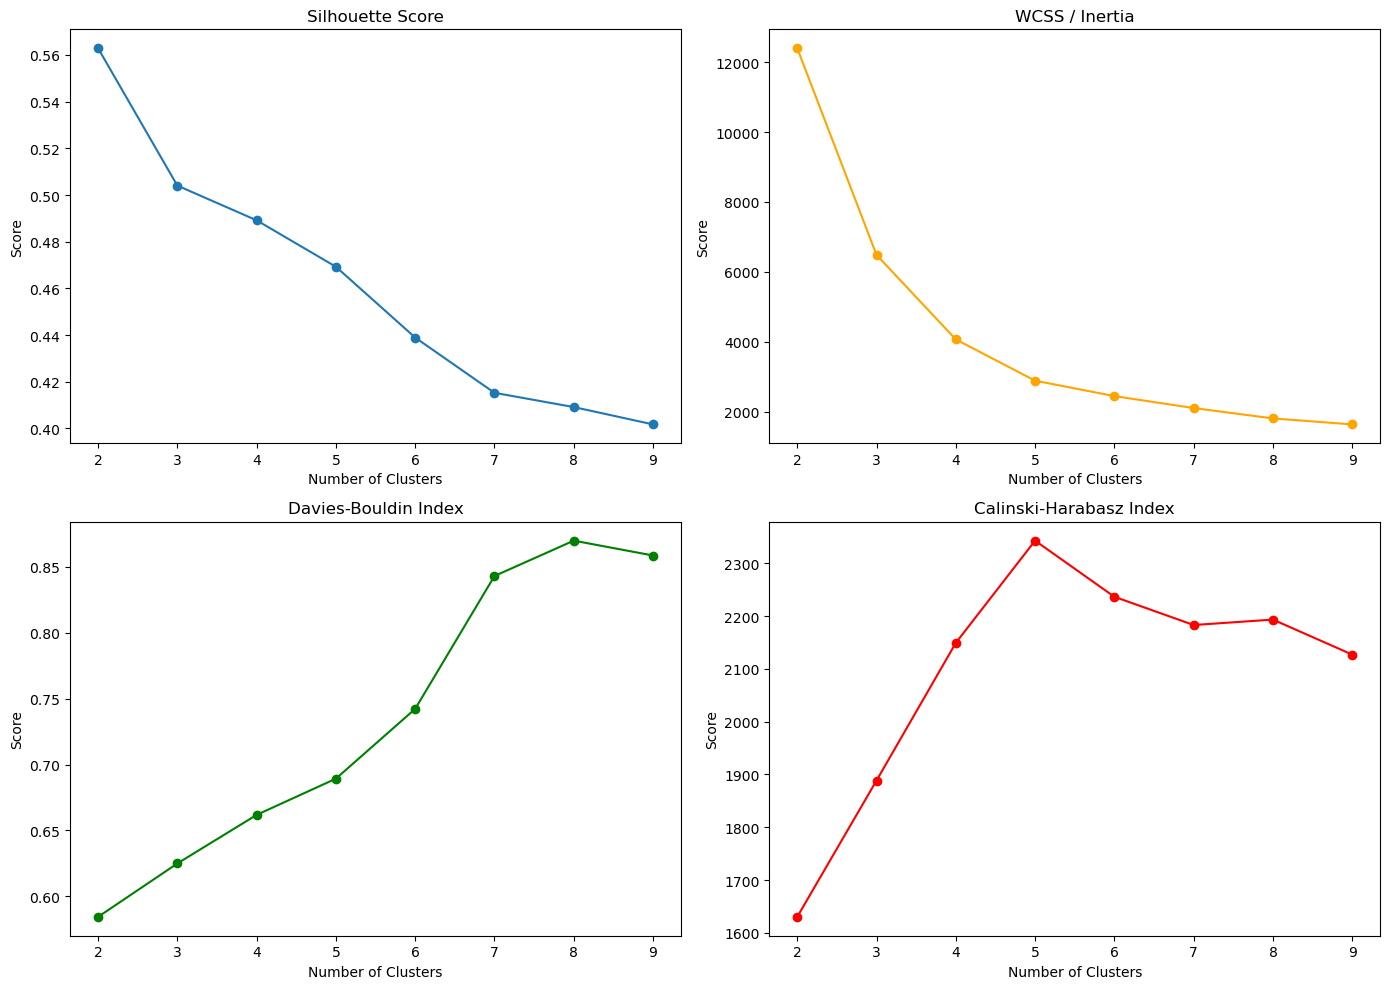

Finished 'plot_cluster_metrics' in 1.5716 secs


C:\Users\jmlam\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


Finished 'apply_clustering' in 0.7280 secs


C:\Users\jmlam\AppData\Local\Temp\ipykernel_17420\581768135.py:252: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_df["labels"] = labels


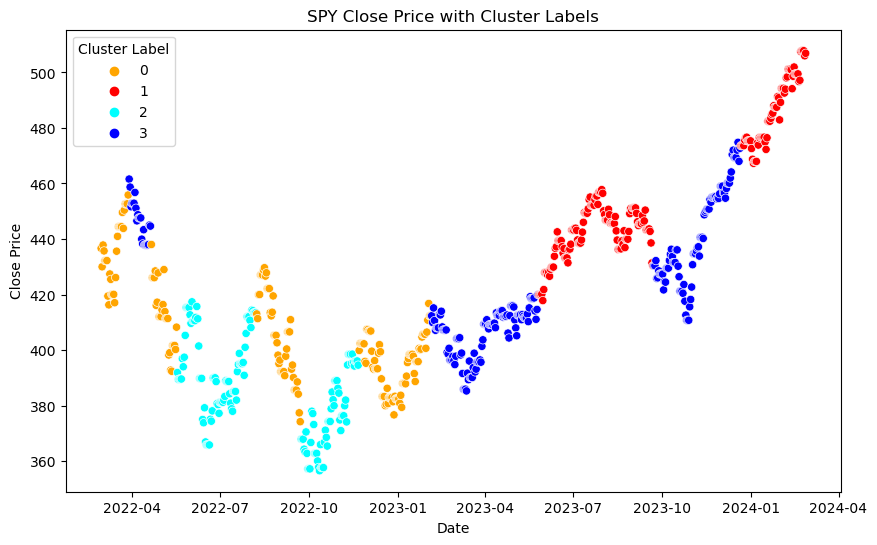

C:\Users\jmlam\AppData\Local\Temp\ipykernel_17420\581768135.py:252: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_df["labels"] = labels


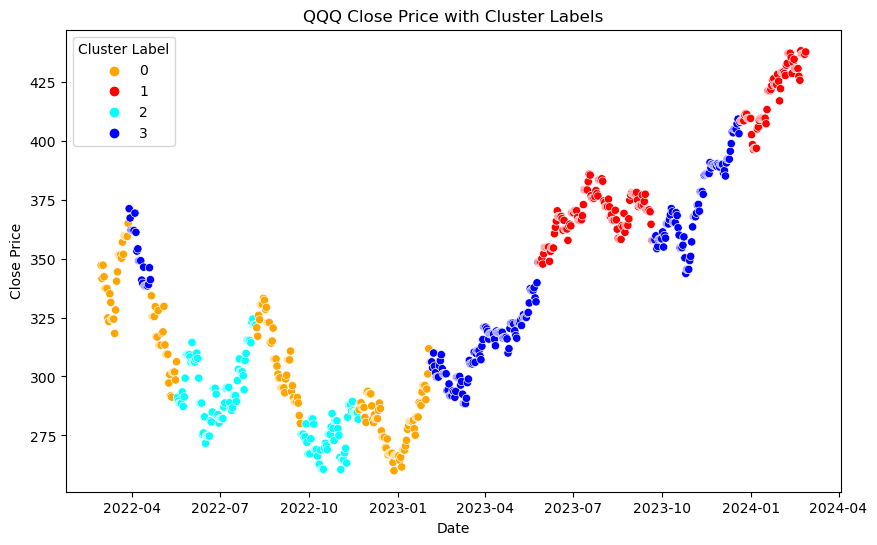

C:\Users\jmlam\AppData\Local\Temp\ipykernel_17420\581768135.py:252: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_df["labels"] = labels


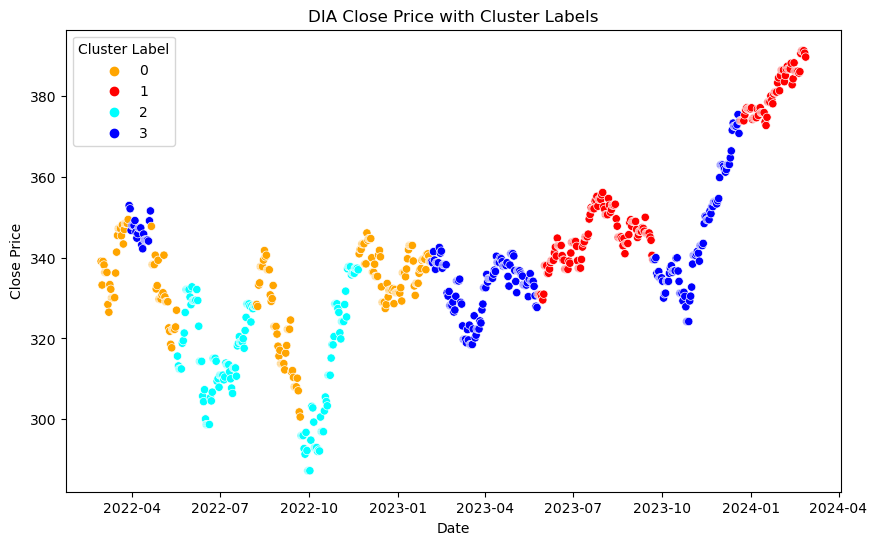

Finished 'plot_clustered_tickers' in 2.7171 secs
CPU times: total: 1min 27s
Wall time: 49 s


In [10]:
%%time
df = load_data(filename, advanced_imputation=None)
dailydf = df.groupby("Ticker").apply(aggregate_to_daily).reset_index().drop("level_1",axis=1).replace(0,np.nan).fillna(method="ffill").fillna(method="bfill")
fe_df = feature_engineering(dailydf)
avgdf = aggregate_data(fe_df)
# avgdf.to_csv("avgdf.csv")
# avgdf = pd.read_csv("avgdf.csv")
kmeans_metrics = calculate_metrics(avgdf, cluster_range=10)
plot_cluster_metrics(kmeans_metrics)
plot_clustered_tickers(dailydf, avgdf, tickers=["SPY", "QQQ", "DIA"])

The exploration into financial markets' inherent structures and dynamics stands as a testament to the potential of machine learning in uncovering complex patterns. By leveraging technical indicators as features and employing KMeans clustering, the project offers deep insights into the relationships between stocks, thus providing a solid foundation for further analysis and decision-making in the financial domain.

Discussion:

The project’s strength lies in its comprehensive feature engineering process, where various technical indicators were utilized to capture the essence of stock movements. These indicators, reflecting aspects such as trend, momentum, and volatility, allowed for a nuanced differentiation between stocks based on their historical trading behavior. It's important to clarify that while PCA was mentioned in the initial workflow, the final analysis focused on direct clustering of these engineered features without applying PCA for dimensionality reduction. This direct approach to clustering, based on raw and scaled features, ensures that the full complexity and subtleties of stock market data are considered in the clustering process.

The decision-making process regarding the optimal number of clusters highlights the project's methodological rigor. By evaluating metrics such as silhouette scores, Davies-Bouldin index, and Calinski-Harabasz index, the project balanced statistical validity with interpretability, ensuring that the clusters formed were both meaningful and actionable.

Conclusion:

The findings of this project illustrate the utility of unsupervised learning in financial market analysis, particularly in identifying clusters of stocks with similar trading patterns. These clusters not only offer insights into the market's structure but also have practical implications for portfolio management, risk assessment, and the development of investment strategies. Identifying groups of stocks that move together can aid in diversification strategies and risk management by understanding the underlying factors that drive market segments.

Furthermore, this project underscores the importance of feature selection in machine learning applications to financial data. The use of technical indicators as features directly, without the application of PCA for dimensionality reduction, emphasizes the need for domain knowledge and careful feature engineering in achieving meaningful clustering results.

However, it's crucial to acknowledge the limitations of this approach, particularly the reliance on historical data and the assumption that past trading patterns will continue in the future. Financial markets are influenced by a wide range of unpredictable factors, and thus, the results of such analysis should be integrated with broader market analysis and not used in isolation.

Future directions for this research could include the integration of alternative or additional features, such as fundamental analysis indicators or sentiment analysis from financial news. Also, experimenting with different clustering algorithms or incorporating supervised learning techniques for predictive modeling could provide more comprehensive insights into market dynamics.

In conclusion, this project provides a valuable perspective on the application of unsupervised learning in the financial domain, highlighting both the potential and the challenges of leveraging machine learning to decipher the complex world of stock market investments.